In [1]:
%load_ext autoreload
%autoreload 2

from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import jax.numpy as jnp

import jaxley as jx
from jaxley.channels import Leak, HH
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import connect

from jaxley_mech.synapses import GapJunction

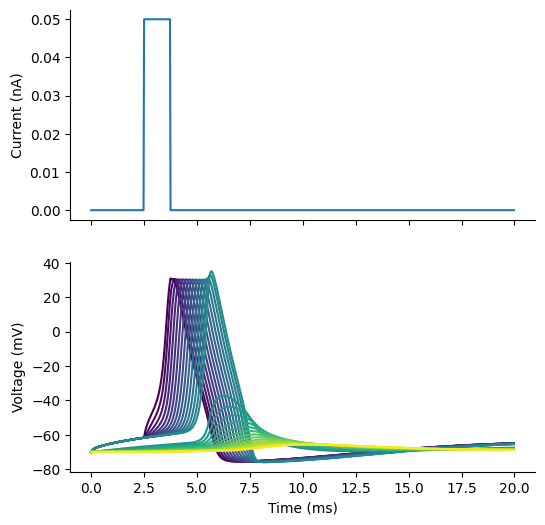

In [2]:
n_cells = 2
dt = 0.025
t_max = 20
gE = 0.001
_ = np.random.seed(0)

# Define a compartment, branch, and cell
comp = jx.Compartment()
branch = jx.Branch(comp, ncomp=16)
cell = jx.Cell(branch, parents=[-1])

# Define the network and connectivity
network = jx.Network([cell for _ in range(n_cells)])
connect(
    network.cell(0).branch(0).comp(15), network.cell(1).branch(0).comp(0), GapJunction()
)
network.GapJunction.set("GapJunction_gE", gE)

# Insert mechanisms
network.cell(0).insert(HH())
network.cell(1).insert(Leak())

network.delete_recordings()
for i in range(16):
    network.cell(0).branch(0).loc(i / 16).record(verbose=False)
for i in range(16):
    network.cell(1).branch(0).loc(i / 16).record(verbose=False)

time = jnp.arange(0, t_max, step=dt)
inp_current = jnp.zeros_like(time)
inp_current = inp_current.at[100:150].set(0.05)

data_stimuli = None
data_stimuli = (
    network.cell(0)
    .branch(0)
    .comp(0)
    .data_stimulate(inp_current, data_stimuli=data_stimuli)
)

v = jx.integrate(
    network, t_max=t_max, delta_t=dt, solver="fwd_euler", data_stimuli=data_stimuli
)

colors = plt.cm.viridis(np.linspace(0, 1, v.shape[0]))

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

_ = ax[0].plot(time, inp_current)
for i in range(v.shape[0]):
    ax[1].plot(time, v[i, :-1], color=colors[i])

ax[0].set_ylabel("Current (nA)")
ax[1].set_ylabel("Voltage (mV)")
ax[1].set_xlabel("Time (ms)")
sns.despine();

### Using Implicit Euler

There may have been concern that gap junctions would make the system too stiff, so there would be a chance that the implicit Euler method would return a different (more accurate) result.

Increasing `gE` does in fact make the forward Euler integration unstable while the backward Euler method continues to manage. However, for a coupling constant unreasonably high, the backward Euler integration also becomes unstable.

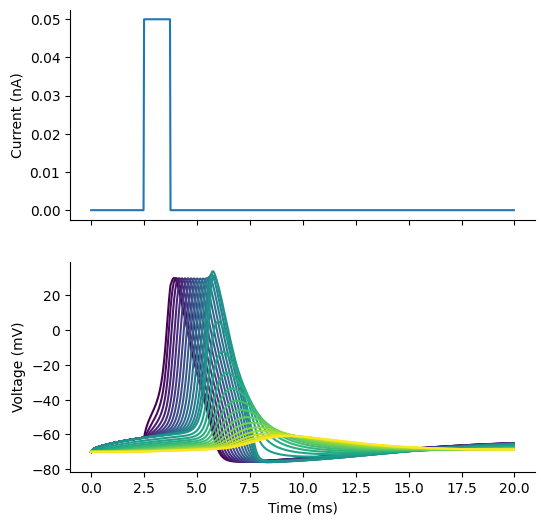

In [3]:
network.GapJunction.set("GapJunction_gE", 0.05)  # fwd_euler cannot handle gE this large

v = jx.integrate(
    network, t_max=t_max, delta_t=dt, solver="bwd_euler", data_stimuli=data_stimuli
)

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

_ = ax[0].plot(time, inp_current)
for i in range(v.shape[0]):
    ax[1].plot(time, v[i, :-1], color=colors[i])

ax[0].set_ylabel("Current (nA)")
ax[1].set_ylabel("Voltage (mV)")
ax[1].set_xlabel("Time (ms)")
sns.despine();

In [4]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2025-02-21 09:30:13CET

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 8.32.0

seaborn    : 0.13.2
jax        : 0.4.31
jaxley     : 0.6.2
numpy      : 2.2.3
jaxley_mech: 0.3.0
matplotlib : 3.10.0

Watermark: 2.5.0

